In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import datetime as DT
import pandas as pd
import math
import scipy
from IPython.core.debugger import Tracer

from sklearn import datasets, linear_model
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
#from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

%matplotlib inline
import seaborn as sns; sns.set()
import operator
import itertools
import matplotlib.patches as mpatches
from scipy.stats.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')
#Tracer()()
def prep (a):
    return a.reshape(a.shape[0], 1)
def unprep (a):
    return np.squeeze(a)
def figurefullwidth():
    plt.figure(figsize=(25,5));
def subplot(a):
    plt.subplot(1,3,a);
def subplottitle(a, b):
    ax = plt.subplot(1, 3, a)
    ax.set_title(b)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Read in the Data

In [4]:
#load data
df = pd.read_csv('/Users/david/notebooks/data/LFB incident data 1 Jan 2009 to 31 Aug 2015/LFB incident data 1 Jan 2009 to 31 Dec 2011.csv', header= 0)
df["DateOfCall"] = pd.to_datetime(df["DateOfCall"]+ ' ' + df['TimeOfCall'], infer_datetime_format=True)
#a=np.datetime64('2002-06-28').astype(datetime)
del df['TimeOfCall']
#df = df.drop(df3.columns[3], axis=1)
#df = df.drop(df3.columns[6], axis=1)
df.shape
df.head()
d = 3
d

(376145, 26)

,IncidentNumber,DateOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,...,Easting_rounded,Northing_rounded,FRS,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending
0,235138081,2009-01-01 00:00:37,Special Service,Special Service,RTC,Road Vehicle,Car,In street close to,SW11 4LB,SW11,...,528650,176850,London,Battersea,319.0,Battersea,342.0,Clapham,2.0,2.0
1,1091,2009-01-01 00:00:46,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,Open land/water - nearest address to access,SE1 7SG,SE1,...,530450,179050,London,Lambeth,NaN,NaN,NaN,NaN,NaN,NaN
2,2091,2009-01-01 00:03:00,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,In street outside,N9 9EL,N9,...,533750,194450,London,Edmonton,308.0,Edmonton,NaN,NaN,1.0,1.0
3,3091,2009-01-01 00:04:27,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,UB10 0DG,UB10,...,507750,182850,London,Hillingdon,210.0,Hillingdon,NaN,NaN,1.0,1.0
4,5091,2009-01-01 00:05:39,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,In street outside,N7 8HG,N7,...,531050,185350,London,Holloway,233.0,Holloway,250.0,Holloway,1.0,2.0


3

In [5]:
df.shape
df.columns
#describe the data
df.describe()
df.describe(include = ['O'])
df.dtypes

(376145, 26)

Index(['IncidentNumber', 'DateOfCall', 'IncidentGroup', 'StopCodeDescription',
       'SpecialServiceType', 'PropertyCategory', 'PropertyType',
       'AddressQualifier', 'Postcode_full', 'Postcode_district',
       'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'IncGeo_WardCode',
       'IncGeo_WardName', 'Easting_m', 'Northing_m', 'Easting_rounded',
       'Northing_rounded', 'FRS', 'IncidentStationGround',
       'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_AttendanceTime',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending'],
      dtype='object')

,IncidentNumber,Easting_m,Northing_m,Easting_rounded,Northing_rounded,FirstPumpArriving_AttendanceTime,SecondPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending
count,3.761450e+05,218081.000000,218081.000000,376145.000000,376145.000000,340231.000000,129848.000000,373668.000000,373668.000000
mean,1.100617e+08,530721.301709,180395.434293,530767.393824,180561.359715,327.839139,397.839874,1.351874,1.585613
std,6.520072e+07,10460.567378,7476.013872,9763.172085,7284.982303,148.046202,163.932126,0.613043,0.825206
min,1.091000e+03,459886.000000,145768.000000,459850.000000,145750.000000,1.000000,7.000000,1.000000,1.000000
25%,5.276211e+07,NaN,NaN,525450.000000,176450.000000,NaN,NaN,NaN,NaN
50%,1.092081e+08,NaN,NaN,531050.000000,181050.000000,NaN,NaN,NaN,NaN
75%,1.666701e+08,NaN,NaN,536350.000000,185050.000000,NaN,NaN,NaN,NaN
max,2.351381e+08,628647.000000,230863.000000,628650.000000,230850.000000,1200.000000,1200.000000,32.000000,46.000000


,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,IncGeo_BoroughCode,IncGeo_BoroughName,IncGeo_WardCode,IncGeo_WardName,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_DeployedFromStation
count,376145,376145,111578,375469,376145,376145,218081,376145,376145,376145,376145,376145,376145,376145,340231,129848
unique,3,9,20,9,264,11,63885,378,34,34,650,634,2,115,112,112
top,False Alarm,AFA,Lift Release,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident address,SW17 0QT,SE1,E09000033,Westminster,E05000649,West End,London,Soho,Soho,Hammersmith
freq,180376,130050,31260,156013,39697,183393,553,7480,27554,27554,6131,6131,374522,11337,10112,3218


IncidentNumber                                     int64
DateOfCall                                datetime64[ns]
IncidentGroup                                     object
StopCodeDescription                               object
SpecialServiceType                                object
PropertyCategory                                  object
PropertyType                                      object
AddressQualifier                                  object
Postcode_full                                     object
Postcode_district                                 object
IncGeo_BoroughCode                                object
IncGeo_BoroughName                                object
IncGeo_WardCode                                   object
IncGeo_WardName                                   object
Easting_m                                        float64
Northing_m                                       float64
Easting_rounded                                    int64
Northing_rounded               

In [6]:
#separate the numberical and categorical clolumns
colnum = []
colcat = []
for col in df:
    if(df[col].dtype == object):
        colcat.append(col)
    else:
        colnum.append(col)
len(colnum)
len(colcat)

10

16

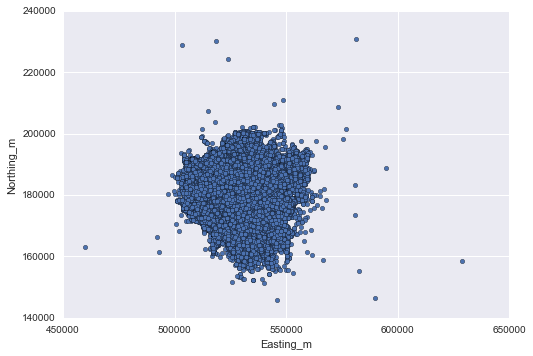

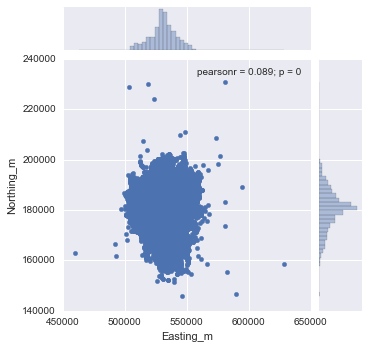

In [16]:
#seaborn functions
#---------------------
#df.plot(kind="scatter", x=colnum[2], y=colnum[3])
sns.jointplot(x=colnum[2], y=colnum[3], data=df, size=5)
#sns.FacetGrid(iris, hue="Species", size=5) \
#   .map(plt.scatter, "SepalLengthCm", "SepalWidthCm") \
#   .add_legend()
#sns.FacetGrid(iris, hue="Species", size=6) \
#   .map(sns.kdeplot, "PetalLengthCm") \
#   .add_legend()
#sns.pairplot(iris.drop("Id", axis=1), hue="Species", size=3,diag_kind="kde")

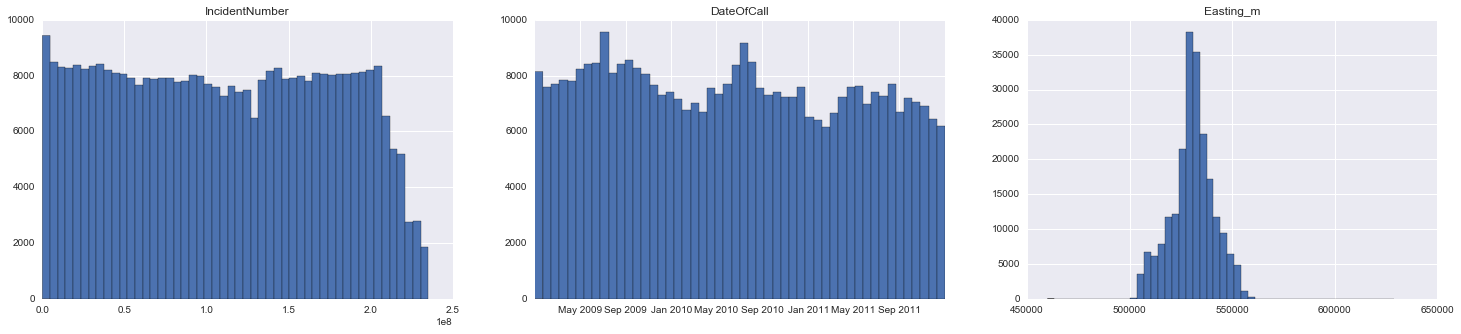

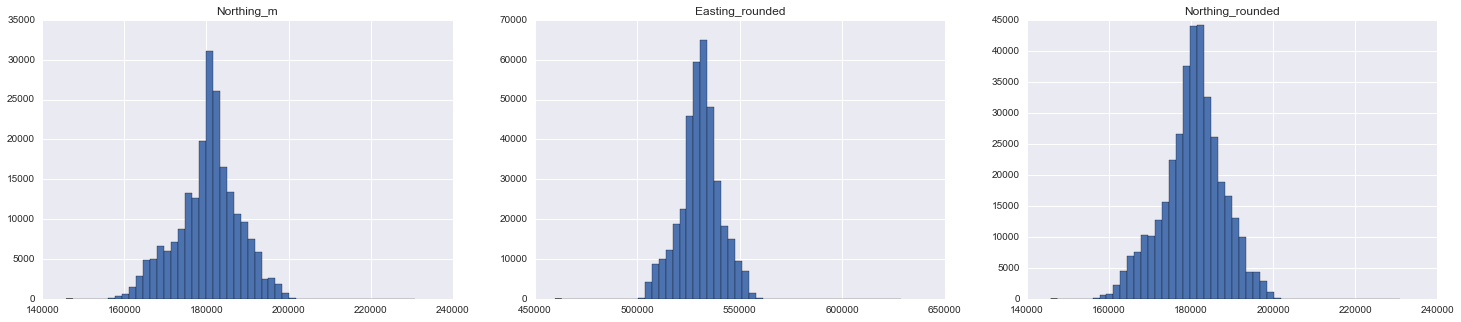

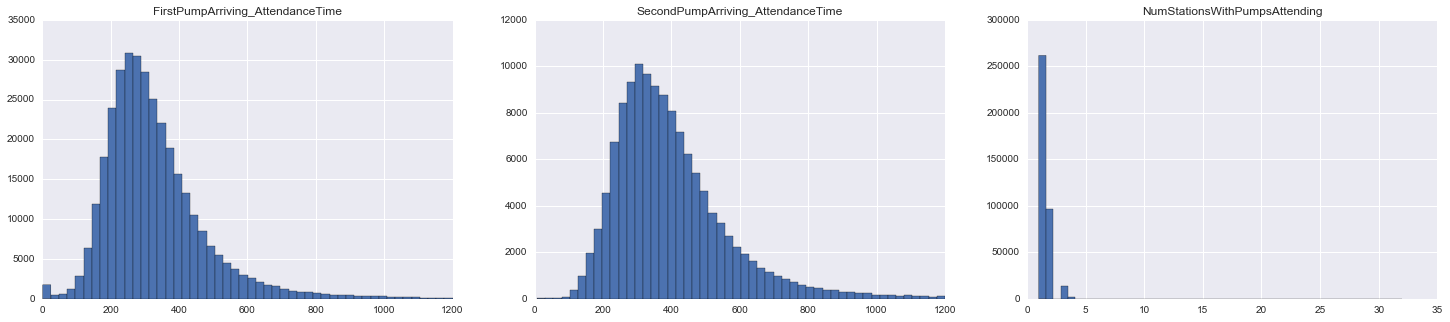

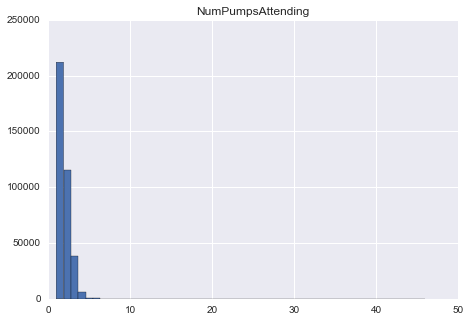

In [8]:
#examine the numberical categories
def plotcolnumerical(c):
    a = 0
    for i in range(len(c)):
        if(a==0):
            figurefullwidth()
        subplot(a+1)
        _ = df[c[i]].hist(bins=50)
        subplottitle(a+1, c[i])
        a+=1
        if(a==3):
            a = 0
plotcolnumerical(colnum)
#df.boxplot(column='ApplicantIncome', by = 'Education')

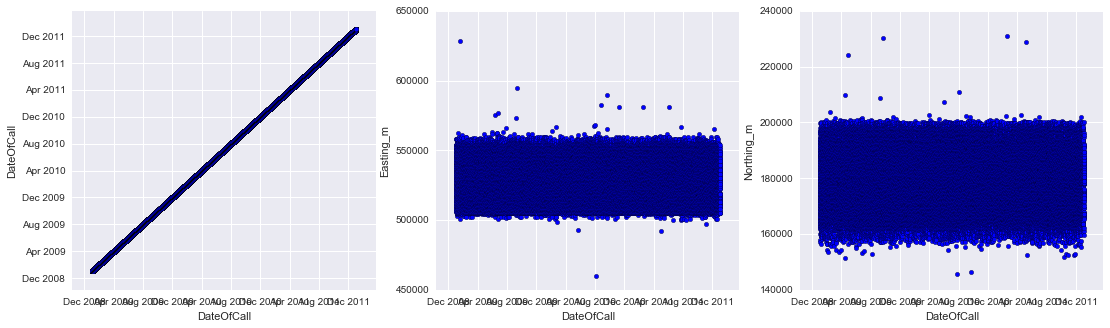

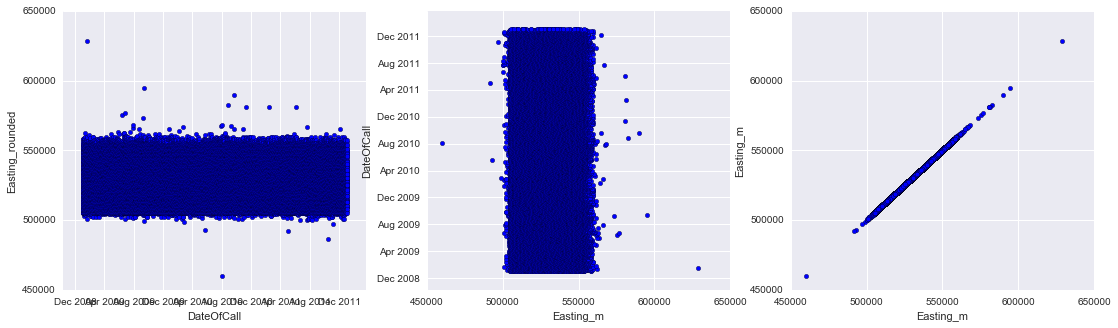

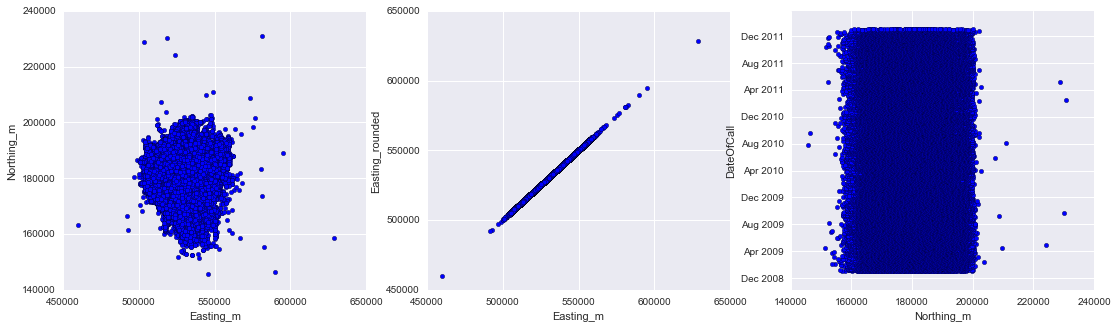

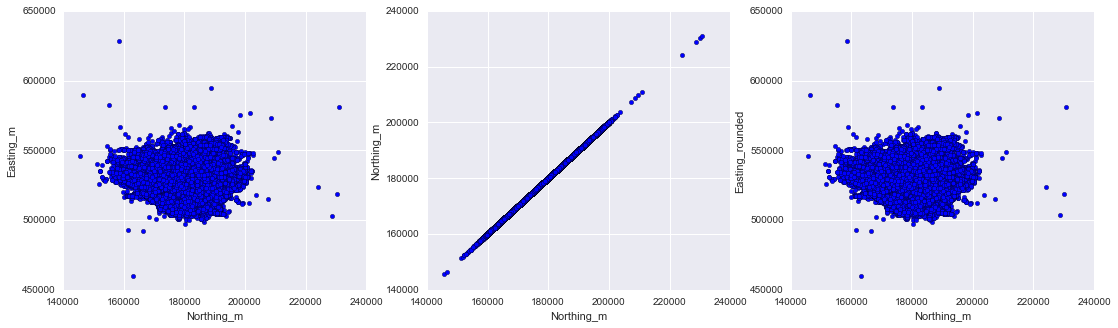

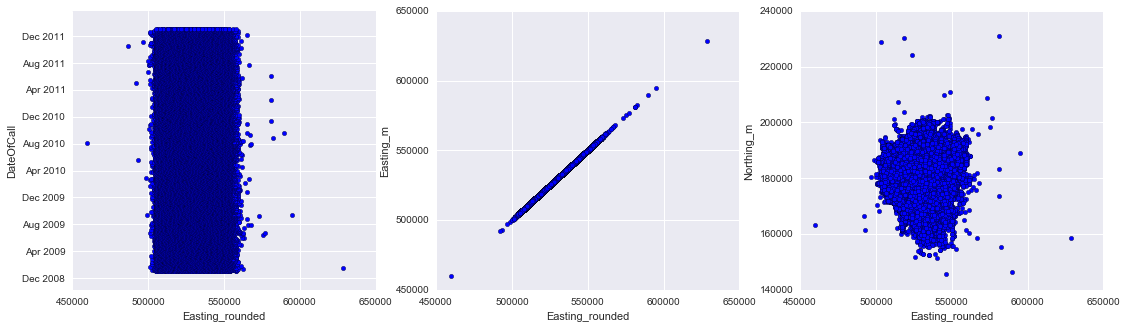

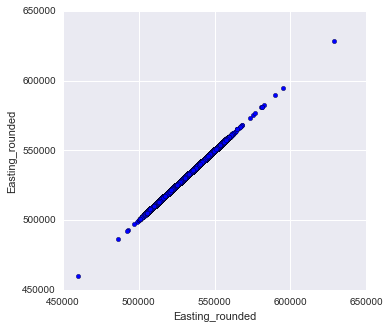

In [9]:
#examine the numberical categories
def plotcolnumericalagainst(c):
    a = 0
    for i in range(len(c)):
        for j in range(len(c)):
            if (a == 0):
                figurefullwidth()
            ax = plt.subplot(1, len(c), a + 1)
            x = df[c[i]]
            y = df[c[j]]
            if(x.dtype == "datetime64[ns]"):
                x = [date.to_datetime() for date in x]
            if(y.dtype == "datetime64[ns]"):
                y =  [date.to_datetime() for date in y]
                
            #subplot(a+1)
            #if(df[c[i]].dtype == datetime)
            plt.scatter(x, y, c='b')
            #_ = df[c[i]].hist(bins=50)
            ax.set_ylabel(c[j])
            ax.set_xlabel(c[i])
            #subplottitle(a+1, c[i])
            a += 1
            if (a == len(c) - 1):
                a = 0

#df.dtypes
#import matplotlib.dates as mdates
#mdates.strpdate2num('%Y-%m-%d')
#df[colnum[1]].astype(DT.datetime).values[0]
#df[colnum[1]].astype(DT.datetime).values[0].to_datetime()

#[date.to_datetime() for date in df[colnum[1]]]

plotcolnumericalagainst(colnum[1:5])
#df.boxplot(column='ApplicantIncome', by = 'Education')

In [10]:
#df.loc[:, df.dtypes == object].unique()
#df.loc[:, df.dtypes == object]

d = {}
d_vals = {}
for col in df:
    if(df[col].dtype == object):
        d[col] = df[col].unique()
        print(col, len(d[col]))
        d_vals[col] = df[col].value_counts()
#d
#d_vals

IncidentGroup 3
StopCodeDescription 9
SpecialServiceType 21
PropertyCategory 10
PropertyType 264
AddressQualifier 11
Postcode_full 63886
Postcode_district 378
IncGeo_BoroughCode 34
IncGeo_BoroughName 34
IncGeo_WardCode 650
IncGeo_WardName 634
FRS 2
IncidentStationGround 115
FirstPumpArriving_DeployedFromStation 113
SecondPumpArriving_DeployedFromStation 113


too many cols  264 PropertyType 4
too many cols  63886 Postcode_full 6
too many cols  378 Postcode_district 7
too many cols  650 IncGeo_WardCode 10
too many cols  634 IncGeo_WardName 11
too many cols  115 IncidentStationGround 13
too many cols  113 FirstPumpArriving_DeployedFromStation 14
too many cols  113 SecondPumpArriving_DeployedFromStation 15


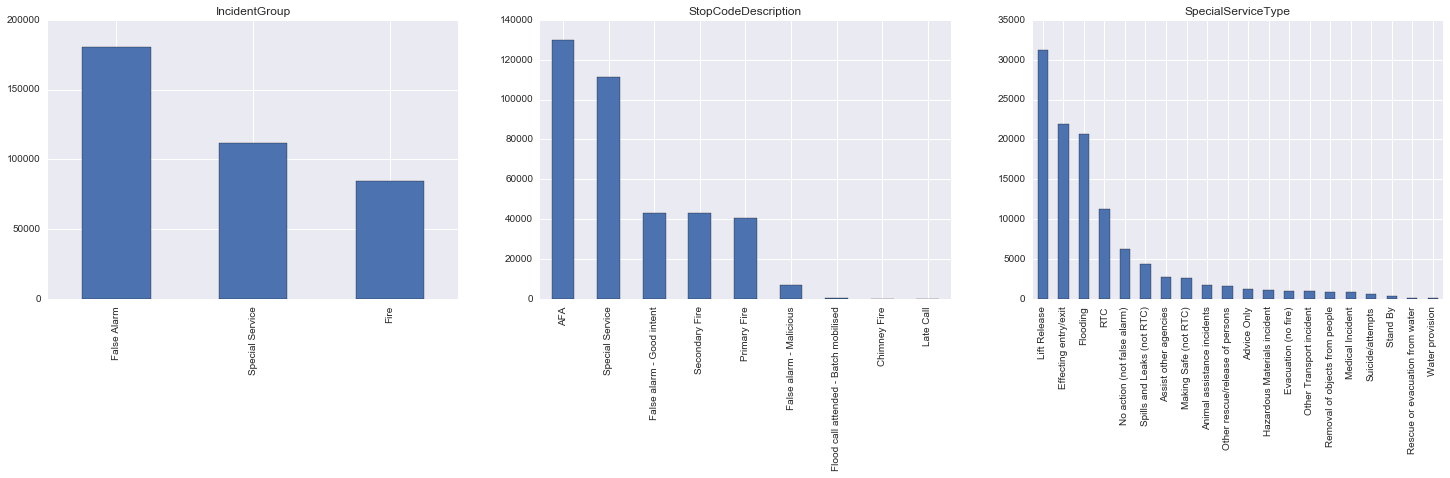

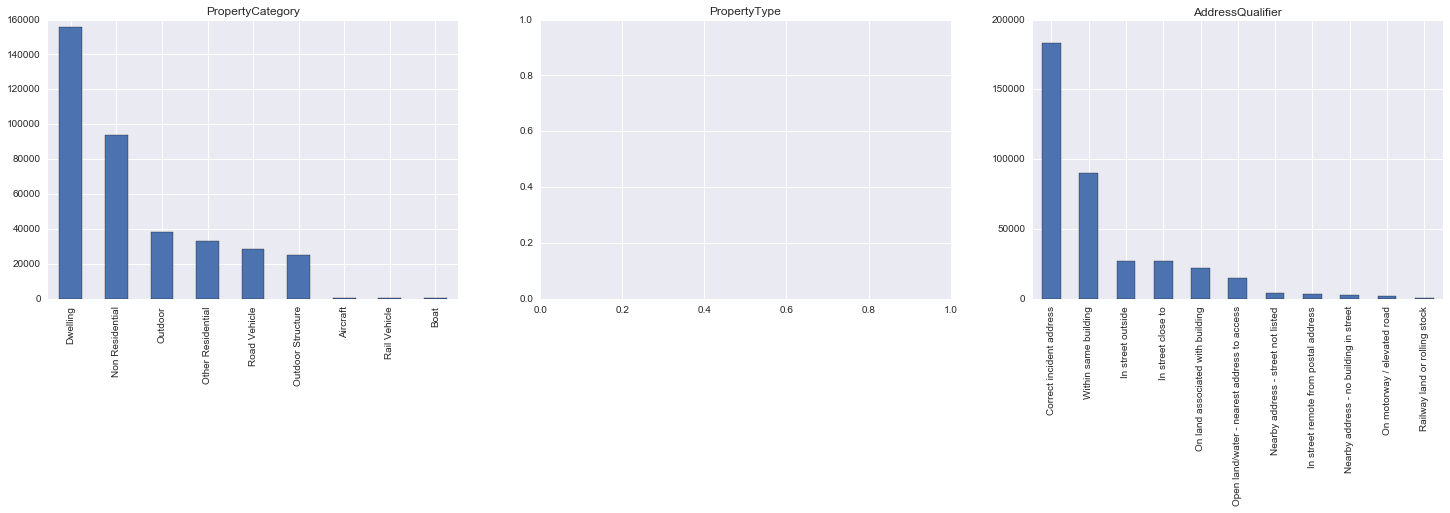

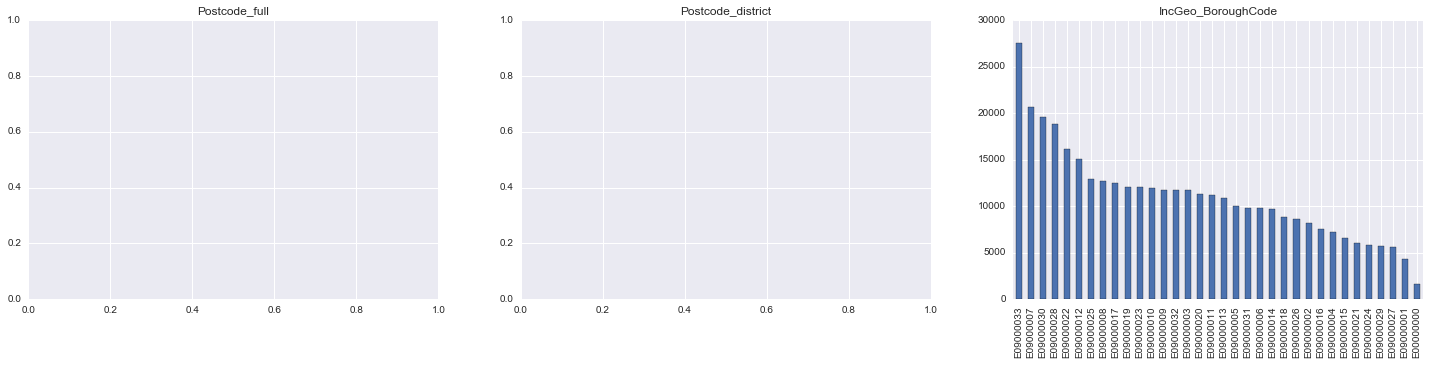

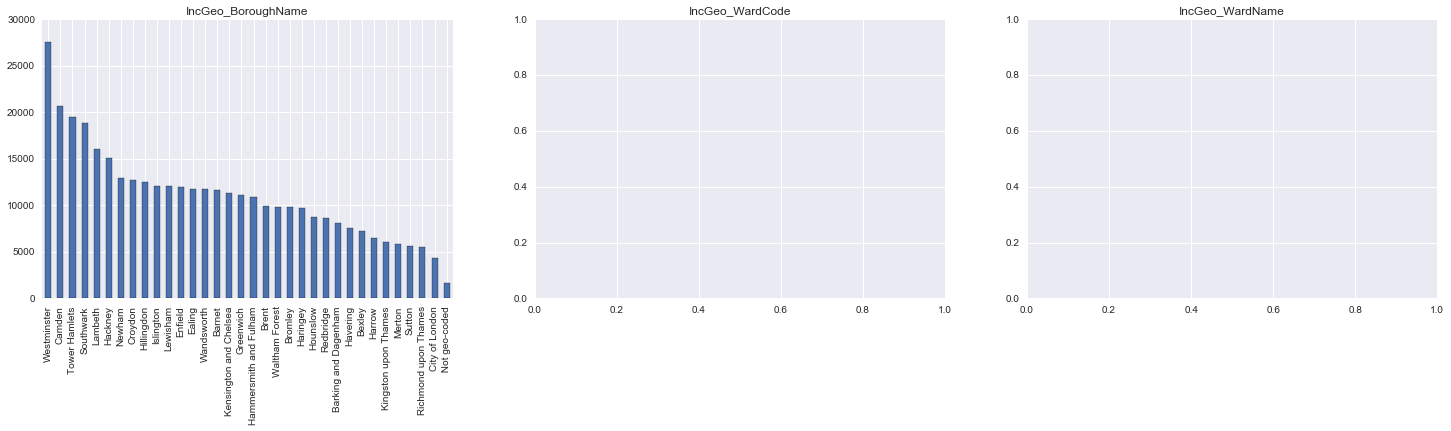

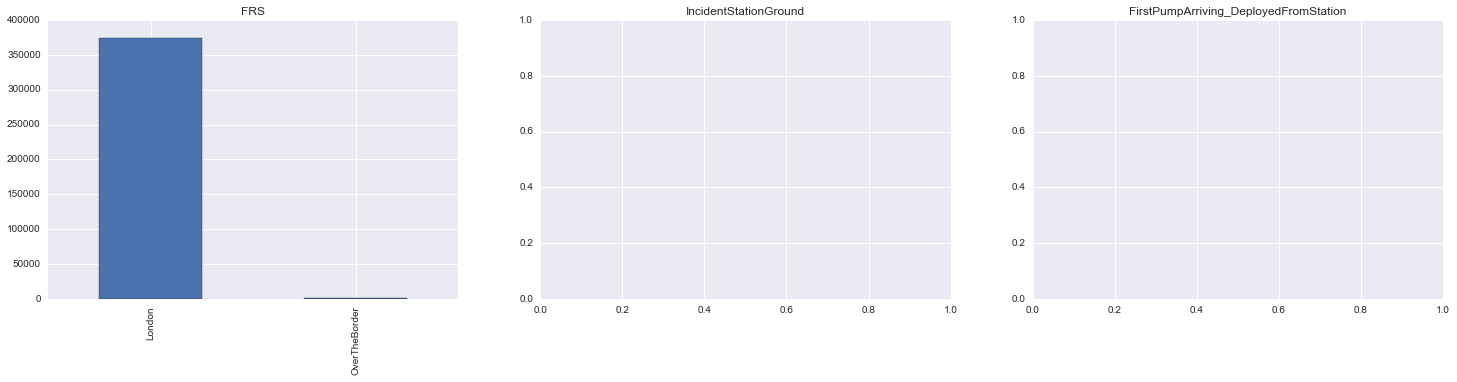

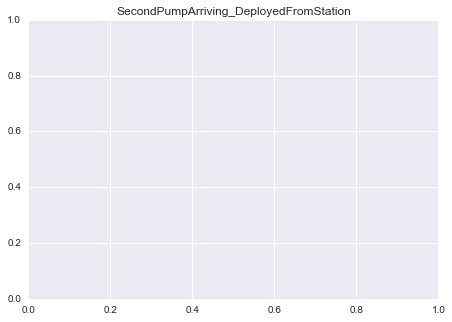

In [11]:
#look at the dist across categories
def plotcolcats(c):
    a = 0
    for i in range(len(c)):
        if(a==0):
            figurefullwidth()
        subplot(a+1)
        if(len(df[c[i]].unique())> 50):
            print ("too many cols ",len(df[c[i]].unique()), c[i], i)
        else:
            _ = df[c[i]].value_counts().plot(kind='bar')
        subplottitle(a+1, c[i])
        #plt.show()
        a+=1
        if(a==3):
            a = 0
plotcolcats(colcat)

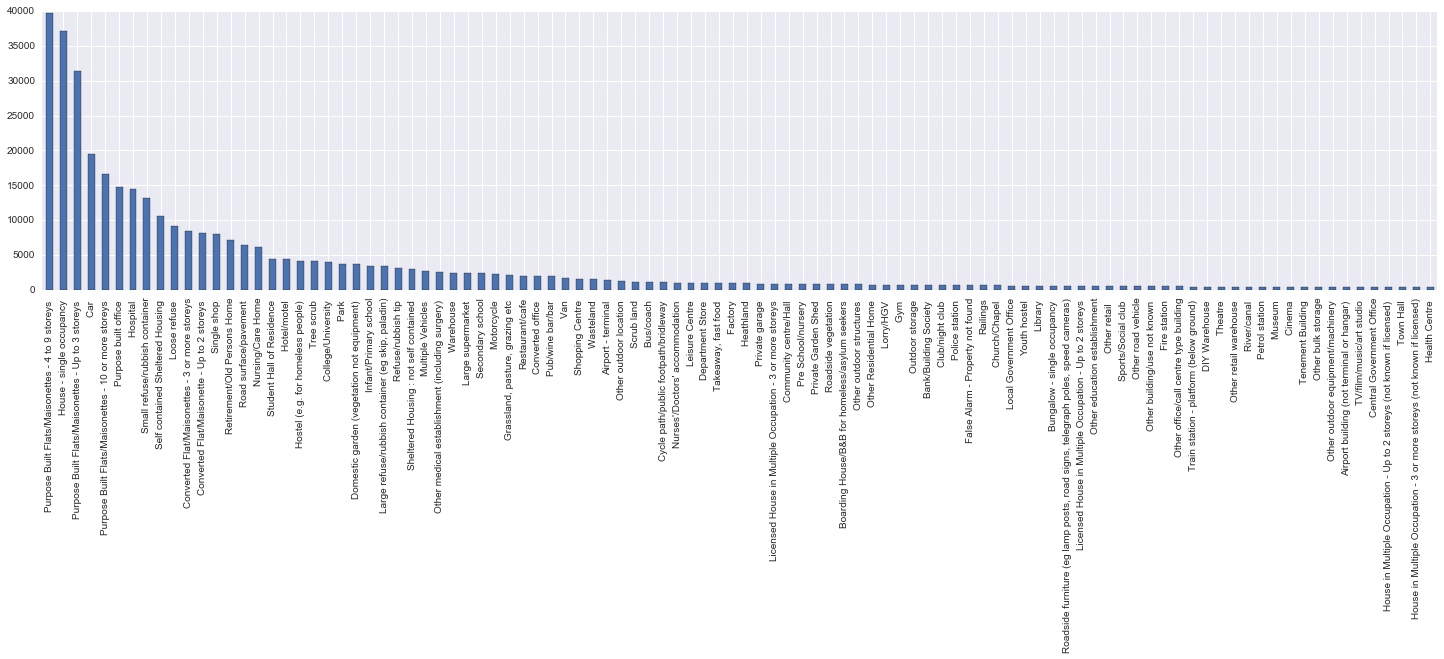

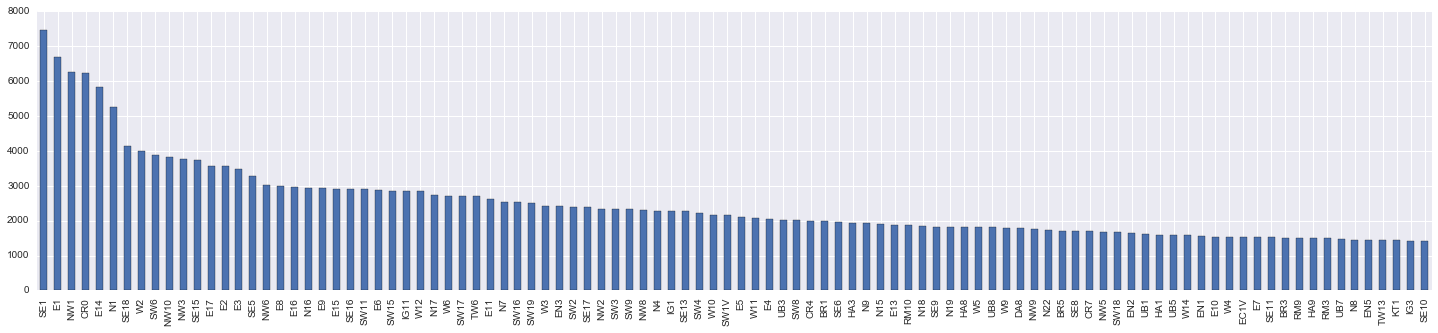

In [12]:
figurefullwidth()
df[colcat[4]].value_counts()[:100].plot(kind='bar')
#figurefullwidth()
#df[colcat[6]].value_counts().plot(kind='bar')
figurefullwidth()
df[colcat[7]].value_counts()[:100].plot(kind='bar')

too many cols  3 PropertyType 4
too many cols  3 Postcode_full 6
too many cols  3 Postcode_district 7
too many cols  3 IncGeo_WardCode 10
too many cols  3 IncGeo_WardName 11
too many cols  3 IncidentStationGround 13
too many cols  3 FirstPumpArriving_DeployedFromStation 14
too many cols  3 SecondPumpArriving_DeployedFromStation 15


'figurefullwidth()\nsubplot(1)\n_vc = df[colcat[0]].value_counts()\n#.index.tolist()\ndf["Year"].values.shape\n_vc.values.shape\nplt.plot(df["Year"].values, _vc.values, c=_vc.index)\n#df[colcat[0]].value_counts().values.tolist()\n'

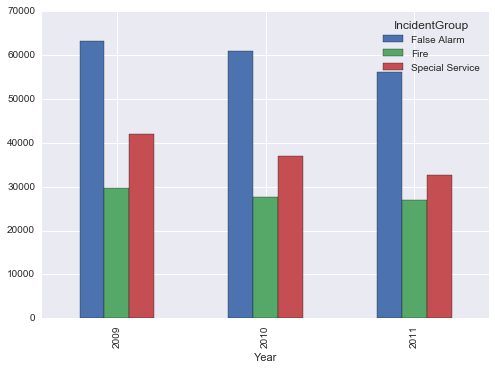

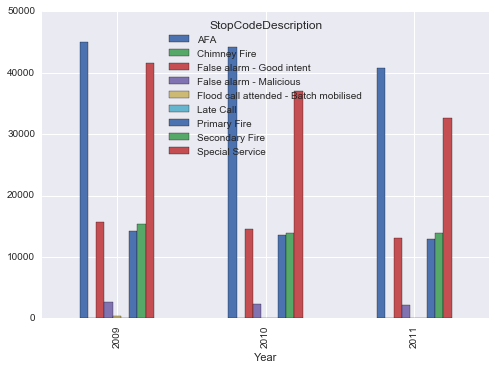

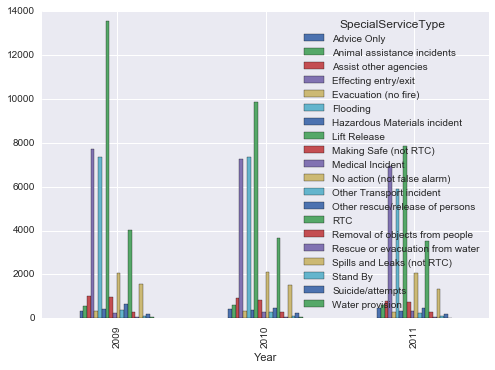

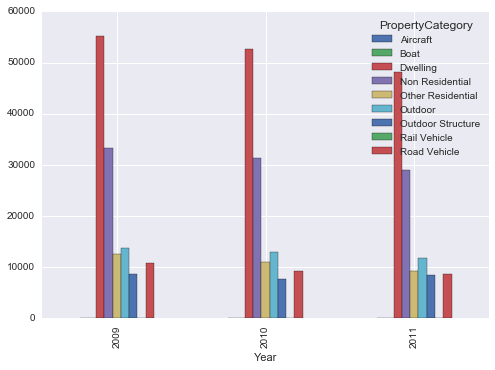

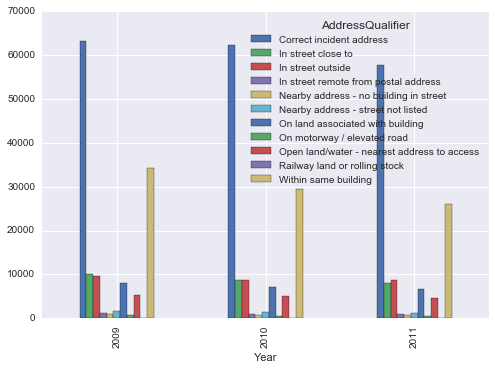

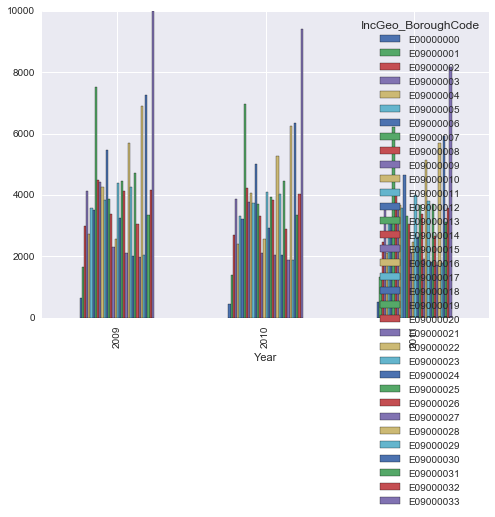

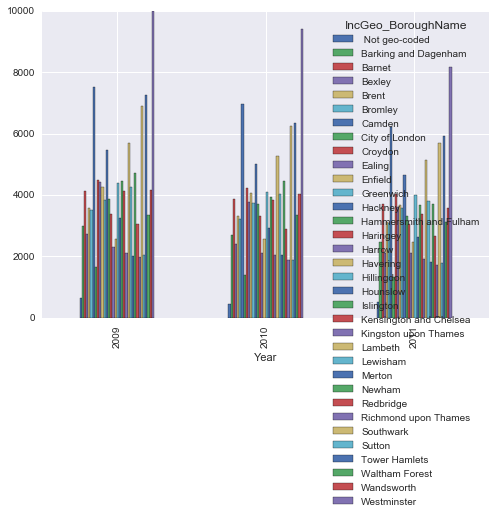

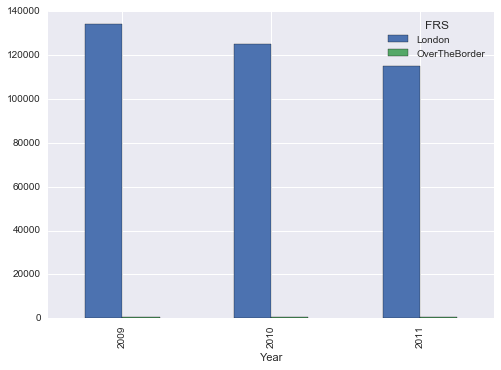

In [13]:
def plotcolcatsbygroup(s, c):
    a = 0
    for i in range(len(c)):
        #if(a==0):
        #    figurefullwidth()
        #subplot(a+1)
        sizes = df.groupby([s,c[i]]).size().unstack()
        l = len(sizes)
        #print(sizes, )
        if(sizes.shape[1]> 50):
            print ("too many cols ",l, c[i], i)
        else:
            sizes.plot(kind='bar')
        #subplottitle(a+1, c[i])
        #plt.show()
        a+=1
        if(a==3):
            a = 0
#Now we start to see what is significant
df["Year"] = df["DateOfCall"].map(lambda x: x.year)
#colcat
#df.pivot(index='Year', columns=colcat[0], values='value')
plotcolcatsbygroup('Year', colcat)

#df.groupby(['Year',colcat[0]]).size().unstack()

#df.pivot_table(index='Year', columns=colcat[0], aggfunc=len, fill_value=0)

#plot cat counts vs numberical
'''figurefullwidth()
subplot(1)
_vc = df[colcat[0]].value_counts()
#.index.tolist()
df["Year"].values.shape
_vc.values.shape
plt.plot(df["Year"].values, _vc.values, c=_vc.index)
#df[colcat[0]].value_counts().values.tolist()
'''

In [14]:
#look at the dist across categories
def plotcolcats(c):
    a = 0
    for i in range(10):
        if(a==0):
            figurefullwidth()
        subplot(a+1)
        if(len(df[colcat[i]].unique())> 50):
            print ("too many cols ",len(df[colcat[i]].unique()), colcat[i], i)
        else:
            _ = df[colcat[i]].value_counts().plot(kind='bar')
        subplottitle(a+1, c[i])
        #plt.show()
        a+=1
        if(a==3):
            a = 0

In [15]:
df[colcat]

#pick a list of columns out of the dataset
def filterdf(cols):
    return df[cols]   















#filter by values
#males = df[(df[Gender]=='Male') & (df[Year]==2014)]



,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,IncGeo_BoroughCode,IncGeo_BoroughName,IncGeo_WardCode,IncGeo_WardName,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_DeployedFromStation
0,Special Service,Special Service,RTC,Road Vehicle,Car,In street close to,SW11 4LB,SW11,E09000032,Wandsworth,E05000620,Queenstown,London,Battersea,Battersea,Clapham
1,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,Open land/water - nearest address to access,SE1 7SG,SE1,E09000022,Lambeth,E05000416,Bishop's,London,Lambeth,NaN,NaN
2,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,In street outside,N9 9EL,N9,E09000010,Enfield,E05000201,Haselbury,London,Edmonton,Edmonton,NaN
3,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,UB10 0DG,UB10,E09000017,Hillingdon,E05000332,Hillingdon East,London,Hillingdon,Hillingdon,NaN
4,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,In street outside,N7 8HG,N7,E09000019,Islington,E05000375,Holloway,London,Holloway,Holloway,Holloway
5,False Alarm,AFA,NaN,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident address,NaN,NW5,E09000007,Camden,E05000139,Kentish Town,London,Kentish Town,Kentish Town,Kentish Town
6,Special Service,Special Service,RTC,Road Vehicle,Car,On motorway / elevated road,SE3 9PP,SE3,E09000011,Greenwich,E05000220,Eltham West,London,Lee Green,East Greenwich,NaN
7,Fire,Secondary Fire,NaN,Outdoor Structure,Refuse/rubbish tip,On land associated with building,TW3 2RE,TW3,E09000018,Hounslow,E05000360,Hounslow South,London,Heston,Heston,Heston
8,Fire,Secondary Fire,NaN,Outdoor Structure,Small refuse/rubbish container,On land associated with building,EC1V 7PB,EC1V,E09000019,Islington,E05000367,Bunhill,London,Clerkenwell,Clerkenwell,NaN
9,False Alarm,AFA,NaN,Other Residential,Student Hall of Residence,Correct incident address,WC1B 3RA,WC1B,E09000007,Camden,E05000129,Bloomsbury,London,Soho,Euston,NaN
